# Prototyping Settings for Simplistic DESC SRD Y1 after PGD implementation and average over 100 maps 

For reference, the DESC SRD can be found [here](https://arxiv.org/pdf/1809.01669.pdf). Appendix D2 specifies some of the analysis choices for the Y1 data. 

In particular:
- neff for lensing sources: 10 gal/arcmin^2
- sigma_e: 0.26 per component
- lmax: 3000

We will use a kappa TNG map as a reference point.

In [1]:
%pylab inline 
import tensorflow_addons as tfa
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import DifferentiableHOS as DHOS
import flowpm.scipy.interpolate as interpolate
import astropy.units as u
import jax_cosmo as jc
import pickle
from flowpm import tfpm
from scipy import ndimage, misc

Populating the interactive namespace from numpy and matplotlib


In [2]:
field_size=5.
field_npix=1024
z_source = np.array([1.])
pix = field_size/field_npix
theta = pix*np.arange(field_npix)

In [3]:
import os
kmaps=[]
ps=[]
for filename in os.listdir("/global/cscratch1/sd/dlan/maps/maps"):
    content =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/maps/maps', filename), 'rb'))
    kmap = content['kmap']
    l,power_spectrum=DHOS.statistics.power_spectrum(kmap[0],field_size,field_npix)
    kmaps.append(kmap)
    ps.append(power_spectrum)


In [4]:
ps=[]
for kmap in kmaps:
    l,power_spectrum=DHOS.statistics.power_spectrum(kmap[0],field_size,field_npix)
    ps.append(power_spectrum)


In [5]:
ps_mean=np.mean(ps,axis=0)

## Comparison to Analytical $halofit$ predictions computed using the jax_cosmo library

In [6]:
cosmo=jc.Planck15()
nz =jc.redshift.delta_nz
(z_source)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, l.numpy(), probes)


TypeError: unsupported operand type(s) for +: 'float' and 'property'

In [ ]:
style.use('seaborn-whitegrid')
loglog(l, l*(l+1)*ps_mean/(2*np.pi),label='DLL')
loglog(l, l*(l+1)*cls[0]/(2*np.pi),'--',label='Analytical $halofit$ predictions')
xlim(1e2,1e4)
ylim(1e-5,4e-2)
axvline(300)
axvline(3000)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
legend()
#savefig('cldll_clhalo_64.png',dpi=250)

## Comparison to kappa TNG

For comparison, we are using this map at redshift 1 from the kappa TNG simulations.

In [ ]:
kTNG_array=[]

for filename in os.listdir("/global/cfs/cdirs/lsst/shared/external/kappaTNG/kappaTNG-Dark"):
    fname=os.path.join('/global/cfs/cdirs/lsst/shared/external/kappaTNG/kappaTNG-Dark',  filename+"/run001/kappa23.dat")
    with open(fname, 'rb') as f:
        dummy = np.fromfile(f, dtype="int32", count=1)
        kappaTNG = np.fromfile(f, dtype="float", count=field_npix* field_npix)
        dummy = np.fromfile(f, dtype="int32", count=1)
    kappaTNG = kappaTNG.reshape((field_npix, field_npix))
    kTNG_array.append(kappaTNG)


In [ ]:
ps_kTNG_array=[]
for kmap in (kTNG_array):
    l,ps=DHOS.statistics.power_spectrum(kmap,field_size,field_npix)
    ps_kTNG_array.append(ps)

In [ ]:
ps_kTNGmean=np.mean(ps_kTNG_array,axis=0)

In [ ]:
style.use('seaborn-whitegrid')
loglog(l, l*(l+1)*ps_mean/(2*np.pi),label='DLL')
loglog(l, l*(l+1)*ps_kTNGmean/(2*np.pi),'--',label='$\kappa$TNG-DARK')
xlim(1e2,1e4)
ylim(1e-5,4e-2)
axvline(3000, ls='--')
axvline(300, ls='--')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
legend()
#savefig('cldll_clktng_64.png',dpi=250)

In [ ]:
figure(figsize=[15,5])
subplot(121)
title('$\kappa$TNG-DARK')
imshow(kTNG_array[0],cmap='viridis')
colorbar()
axis('off')
subplot(122)
title('DLL')
imshow(kmaps[0][0],cmap='viridis')
colorbar()
axis('off')
#savefig('maps_comp.png',dpi=250)

Let's see the maps in the same colorscale 

In [ ]:
# Here is what it looks like with smoothin 
figure(figsize=[15,5])
subplot(121)
title('$\kappa$TNG-DARK')
imshow(kTNG_array[5],cmap='viridis',vmax=0.10,vmin=-0.05)
colorbar()
axis('off')
subplot(122)
title('DLL')
imshow(kmaps[5][0],cmap='viridis',vmax=0.10,vmin=-0.05)
colorbar()
axis('off')
#savefig('maps_comp_same.png',dpi=250)

In [14]:
ps_kTNGstd=np.std(ps_kTNG_array,axis=0)
ps_flowpm_std=np.std(ps,axis=0)

Populating the interactive namespace from numpy and matplotlib


/global/homes/d/dlan/.conda/envs/my_env/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Text(0.5, 1.0, 'Comparison to $\\kappa$$TNG-DARK$')

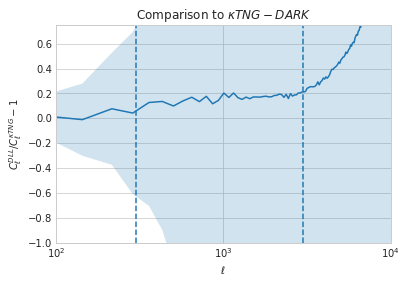

In [15]:
%pylab inline 
y=ps_kTNGmean/ps_mean-1
ci=ps_flowpm_std
fig, ax = plt.subplots()
plt.semilogx(l, y)
xlim(1e2,1e4)
ylim(-1,0.75)
ax.fill_between(l, y-ci/ps_kTNGmean, y+ci/ps_kTNGmean, alpha=.2)
ylabel('$C_{\ell}^{DLL}/C_\ell^{\kappa TNG}-1$')
xlabel('$\ell$')
axvline(3000, ls='--')
axvline(300, ls='--')
title('Comparison to $\kappa$$TNG-DARK$')
#savefig('res_cl_dll_ktng_64.png',dpi=250)

So, obvioulsy our 128^3 simulation is not as precise as kappa TNG, but we won't be working at the native 0.3 arcmin resolution anyway, in practice we'll have noise and smoothing.

So let's see how much smoothing gets us in the right ball park.

In [16]:
ngal = 10                          # gal/arcmin **2
pix_scale =field_size/field_npix*60              # arcmin
ngal_per_pix = ngal * pix_scale**2 # galaxies per pixels
sigma_e = 0.26 / sqrt(2 * ngal_per_pix) # Rescaled noise sigma

In [17]:
sigma_pix=1/pix_scale


In [18]:

def perf_smoothing(kmap):
    kmap= numpy.fft.fft2(kmap)
    kmap =ndimage.fourier_gaussian(kmap, sigma=sigma_pix)
    kmap=numpy.fft.ifft2(kmap)
    kmap=kmap.real
    return kmap

#### 1arcmin smoothing

Populating the interactive namespace from numpy and matplotlib


(-0.5, 1023.5, 1023.5, -0.5)

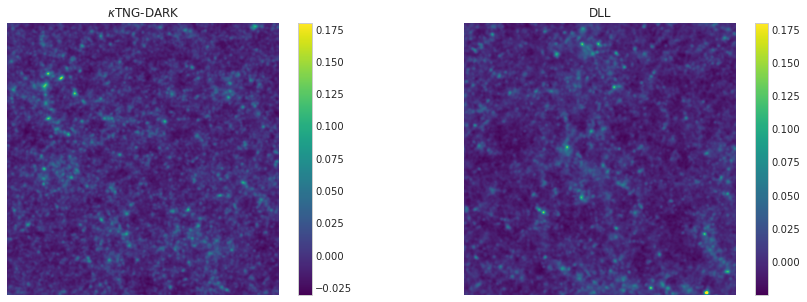

In [19]:
%pylab inline 
figure(figsize=[15,5])
subplot(121)
title('$\kappa$TNG-DARK')
imshow(perf_smoothing(kTNG_array[5]),cmap='viridis',vmax=0.18)
colorbar()
axis('off')

subplot(122)
title('DLL')
imshow(perf_smoothing(kmaps[5])[0],cmap='viridis',vmax=0.18)
colorbar()
axis('off')

In [20]:
ps_FLP_array=[]
for kmap in (kmaps):
    l, ps_FLP= DHOS.statistics.power_spectrum(perf_smoothing(kmap)[0],field_size,field_npix)
    ps_FLP_array.append(ps_FLP)
ps_FLP_mean=np.mean(ps_FLP_array,axis=0)

In [21]:
ps_TNG_array=[]
for kmap in (kTNG_array):
    l, ps_kTNG= DHOS.statistics.power_spectrum(perf_smoothing(kmap),field_size,field_npix)
    ps_TNG_array.append(ps_kTNG)
ps_kTNG_mean=np.mean(ps_TNG_array,axis=0)

Text(0.5, 1.0, 'Comparison to $\\kappa$TNG-DARK with 1-arcmin smoothing')

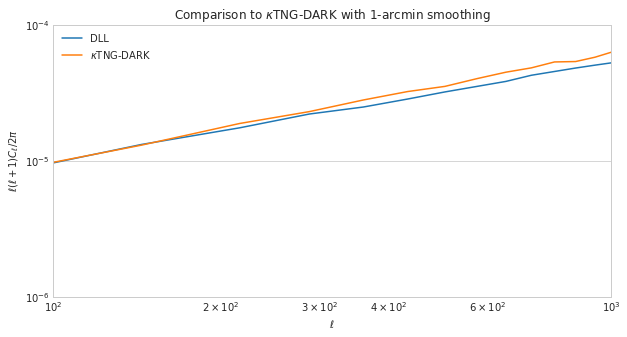

In [22]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps_FLP_mean/(2*np.pi), label='DLL')
loglog(l, l*(l+1)*ps_kTNG_mean/(2*np.pi), label='$\kappa$TNG-DARK')
legend()
axvline(3000, ls='--')
xlim(1e2,1e3)
ylim(1e-6,1e-4)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to $\kappa$TNG-DARK with 1-arcmin smoothing')
#savefig('cl_dll_ktng_64_2smo.png',dpi=250)

In [23]:
ps_kTNG_std=np.std(ps_TNG_array,axis=0)

Text(0.5, 1.0, 'Comparison to $\\kappa$$TNG-$DARK 1-arcmin smoothing')

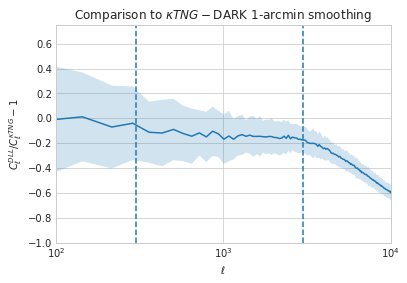

In [24]:
y=ps_FLP_mean/ps_kTNG_mean-1
ci=ps_kTNG_std
fig, ax = plt.subplots()
plt.semilogx(l, y)
axvline(3000, ls='--')
axvline(300, ls='--')
xlim(1e2,1e4)
ylim(-1,0.75)
ax.fill_between(l, y-ci/ps_kTNG_mean, y+ci/ps_kTNG_mean, alpha=.2)
ylabel('$C_{\ell}^{DLL}/C_\ell^{\kappa TNG}-1$')
xlabel('$\ell$')
title('Comparison to $\kappa$$TNG-$DARK 1-arcmin smoothing')
#savefig('res_cl_dll_ktng_64_2smo.png',dpi=250)

## Adding noise

We'll now try to get to a realistic setting that matches some of the SRD Y1 settings.

#### 1arcmin smoothing

In [25]:
ps_FLP_array_n=[]
for kmap in (kmaps):
    kmap= kmap[0]+ sigma_e * randn(1024,1024), 5*u.deg
    l, ps_FLP_n= DHOS.statistics.power_spectrum(perf_smoothing(kmap[0]),field_size,field_npix)
    ps_FLP_array_n.append(ps_FLP_n)
ps_FLP_n_mean=np.mean(ps_FLP_array_n,axis=0)

In [26]:
ps_TNG_array_n=[]
for kmap in (kTNG_array):
    knTNG_n = kmap+ sigma_e * randn(1024,1024), 5*u.deg
    l, ps_kTNG_n= DHOS.statistics.power_spectrum(perf_smoothing(knTNG_n[0]),field_size,field_npix)
    ps_TNG_array_n.append(ps_kTNG_n)
ps_kTNG_n_mean=np.mean(ps_TNG_array_n,axis=0)

Text(0.5, 1.0, 'DLL')

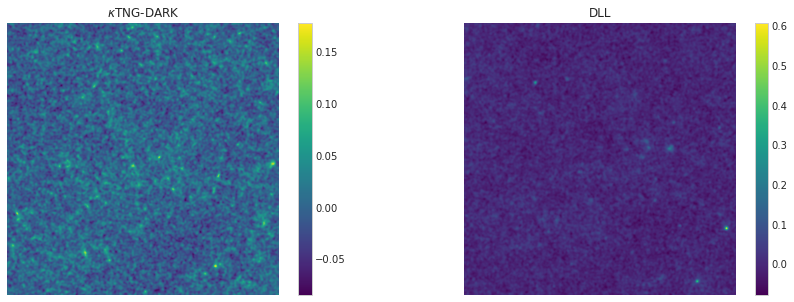

In [27]:
knTNG_n = kTNG_array[0]+ sigma_e * randn(1024,1024), 5*u.deg
kmap_n=kmaps[0][0]+ sigma_e * randn(1024,1024)
# Here is what it looks like with noise 
figure(figsize=[15,5])
subplot(121)
title('$\kappa$TNG-DARK')
imshow(perf_smoothing(knTNG_n[0]),cmap='viridis')
colorbar()
axis('off')
subplot(122)
title('FlowPM')
imshow(perf_smoothing(kmap_n),cmap='viridis')
colorbar()
axis('off')
title('DLL')



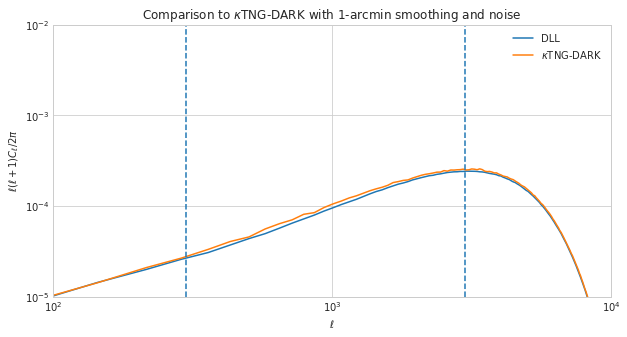

In [28]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps_FLP_n_mean/(2*np.pi), label='DLL')
loglog(l, l*(l+1)*ps_kTNG_n_mean/(2*np.pi), label='$\kappa$TNG-DARK ')
axvline(3000, ls='--')
axvline(300,ls='--')
ylim(10e-6,10e-3)
xlim(1e2,1e4)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to $\kappa$TNG-DARK with 1-arcmin smoothing and noise')
legend()


In [29]:
ps_kTNG_n_std=np.std(ps_TNG_array_n,axis=0)

Text(0.5, 1.0, 'Comparison to $\\kappa$$TNG-$DARK 2-arcmin smoothing and noise')

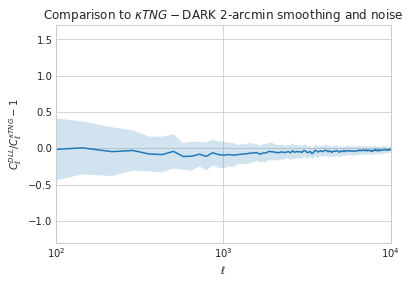

In [30]:
y=ps_FLP_n_mean/ps_kTNG_n_mean-1
ci=ps_kTNG_n_std
fig, ax = plt.subplots()
plt.semilogx(l, y)
ax.fill_between(l, y-ci/ps_kTNG_n_mean, y+ci/ps_kTNG_n_mean, alpha=.2)
ylabel('$C_{\ell}^{DLL}/C_\ell^{\kappa TNG}-1$')
xlabel('$\ell$')
xlim(1e2,1e4)
title('Comparison to $\kappa$$TNG-$DARK 2-arcmin smoothing and noise')
#savefig('cl_comp1_res.png',dpi=250)

## Let's also compare native peak counts

In [31]:
bins_=tf.linspace(-0.029,0.09,8)
#bins_=tf.linspace(-0.035,0.15,16)

In [32]:
counts_FLP_array=[]

for kmap in (kmaps):
    counts_FLP,bins_=DHOS.statistics.peaks_histogram_tf(kmap[0],bins_)
    counts_FLP_array.append(counts_FLP)
    
center_ = (bins_[:-1] + bins_[1:]) / 2
counts_FLP_mean=np.mean(counts_FLP_array,axis=0)

In [33]:
counts_kTNG_array=[]
for kmap in (kTNG_array):
    counts_TNG, bins_TNG=DHOS.statistics.peaks_histogram_tf(np.float32(kmap),bins_)
    counts_kTNG_array.append(counts_TNG)
counts_kTNG_mean=np.mean(counts_kTNG_array,axis=0)

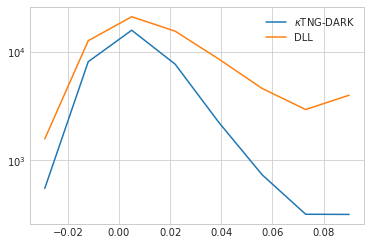

In [34]:
semilogy(bins_, counts_FLP_mean, label='$\kappa$TNG-DARK ')
semilogy(bins_, counts_kTNG_mean, label='DLL')
legend()

In [35]:
counts_kTNG_std=np.std(counts_kTNG_array,axis=0)

Text(0.5, 0, '$\\kappa$')

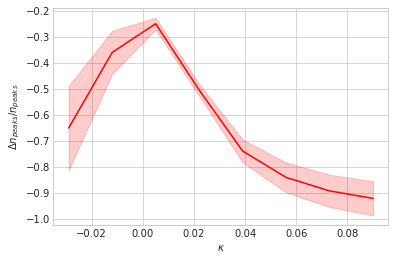

In [36]:
y=(counts_FLP_mean-counts_kTNG_mean)/counts_kTNG_mean
ci=counts_kTNG_std
fig, ax = plt.subplots()
ax.plot(bins_, y, label='$\kappa$TNG-DARK ',color='red')
ax.fill_between(bins_, (y-ci/counts_kTNG_mean), y+ci/counts_kTNG_mean, color='red', alpha=.2)
ylabel('$\Delta$$n_{peaks}/n_{peaks}$')
xlabel('$\kappa$')

## Performing smoothing

#### 1arcmin smoothing

In [37]:
bins_=tf.linspace(-0.029,0.09,8)

In [38]:
counts_FLP_array=[]
for kmap in (kmaps):
    counts_FLP,bins_=DHOS.statistics.peaks_histogram_tf(np.float32(perf_smoothing(kmap[0])),bins_)
    counts_FLP_array.append(counts_FLP)
counts_FLP_mean=np.mean(counts_FLP_array,axis=0)

In [39]:
counts_kTNG_array=[]
for kmap in (kTNG_array):
    counts_TNG, bins_=DHOS.statistics.peaks_histogram_tf(np.float32(perf_smoothing(kmap)),bins_)
    counts_kTNG_array.append(counts_TNG)
counts_kTNG_mean=np.mean(counts_kTNG_array,axis=0)

Text(0.5, 0, '$\\kappa$')

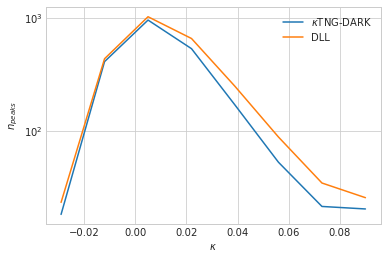

In [40]:
semilogy(bins_, counts_FLP_mean, label='$\kappa$TNG-DARK ')
semilogy(bins_, counts_kTNG_mean, label='DLL')
legend()
ylabel('$n_{peaks}$')
xlabel('$\kappa$')


In [41]:
counts_kTNG_std=np.std(counts_kTNG_array,axis=0)

Text(0.5, 0, '$\\kappa$')

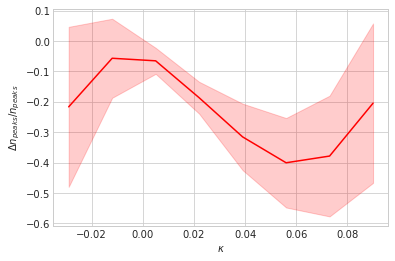

In [42]:
y=counts_FLP_mean/counts_kTNG_mean-1
ci=counts_kTNG_std
fig, ax = plt.subplots()
ax.plot(bins_, y, label='$\kappa$TNG-DARK ',color='red')
ax.fill_between(bins_, (y-ci/counts_kTNG_mean), y+ci/counts_kTNG_mean, color='red', alpha=.2)
ylabel('$\Delta$$n_{peaks}/n_{peaks}$')
xlabel('$\kappa$')

## Adding noise

#### 1arcmin smoothing

In [43]:
counts_FLP_array_n=[]
for kmap in (kmaps):
    kmap= kmap[0]+ sigma_e * randn(1024,1024), 5*u.deg
    counts_FLP,bins_=DHOS.statistics.peaks_histogram_tf(np.float32(perf_smoothing(kmap[0])),bins_)
    counts_FLP_array_n.append(counts_FLP)
counts_FLP_mean_n=np.mean(counts_FLP_array_n,axis=0)

In [44]:
counts_FLP,bins_=DHOS.statistics.peaks_histogram_tf(np.float32(perf_smoothing(kmap[0])),bins_)

In [45]:
counts_kTNG_array_n=[]
for kmap in (kTNG_array):
    knTNG_n = kmap+ sigma_e * randn(1024,1024), 5*u.deg
    counts_TNG, bins_=DHOS.statistics.peaks_histogram_tf(np.float32(perf_smoothing(knTNG_n[0])),bins_)
    counts_kTNG_array_n.append(counts_TNG)
counts_kTNG_mean_n=np.mean(counts_kTNG_array_n,axis=0)

Text(0.5, 0, '$\\kappa$')

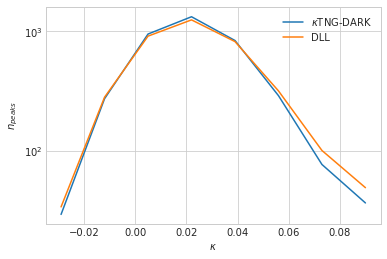

In [46]:
semilogy(bins_, counts_FLP_mean_n, label='$\kappa$TNG-DARK ')
semilogy(bins_, counts_kTNG_mean_n, label='DLL')
legend()
ylabel('$n_{peaks}$')
xlabel('$\kappa$')


In [47]:

counts_kTNG_std_n=np.std(counts_kTNG_array_n,axis=0)

Text(0.5, 0, '$\\kappa$')

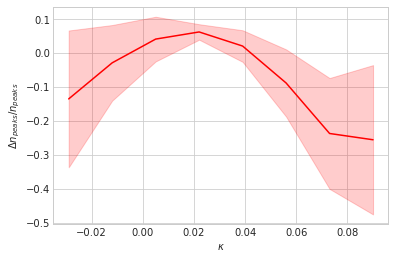

In [48]:
y=counts_FLP_mean_n/counts_kTNG_mean_n-1
ci=counts_kTNG_std_n
fig, ax = plt.subplots()
ax.plot(bins_, y, label='$\kappa$TNG-DARK ',color='red')
ax.fill_between(bins_, (y-ci/counts_kTNG_mean_n), y+ci/counts_kTNG_mean_n, color='red', alpha=.2)
ylabel('$\Delta$$n_{peaks}/n_{peaks}$')
xlabel('$\kappa$')

## Let's also compare the l1norm

In [49]:
l1norm_FLO_array=[] 
for kmap in (kmap_array):
    l1norm_FLO= DHOS.statistics.l1norm(kmap,nscales=7, nbins=16, value_range=[-0.05, 0.05])
    l1norm_FLO_array.append(l1norm_FLO)
l1norm_FLO_mean=np.mean(l1norm_FLO_array,axis=0)

NameError: name 'kmap_array' is not defined

In [ ]:
l1norm_kTNG_array=[] 
for kmap in (kTNG_array):
    kmap=tf.expand_dims(kmap,axis=0)
    l1norm_kTNG= DHOS.statistics.l1norm(np.float32(kmap),nscales=7, nbins=16, value_range=[-0.05, 0.05])
    l1norm_kTNG_array.append(l1norm_kTNG)
l1norm_kTNG_mean=np.mean(l1norm_kTNG_array,axis=0)

In [ ]:
import matplotlib.colors as mcolors

In [ ]:


for i,key in zip(range(8),mcolors.TABLEAU_COLORS):
    semilogy(l1norm_kTNG_mean[i][0], label='scale =' +str(i), color=key)
    semilogy(l1norm_FLO_mean[i][0],'--',color=key)
    
title("Dashed : DLL ; Solid : $\kappa$TNG")
ylabel('$n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
l1norm_kTNG_std_=np.std(l1norm_kTNG_array,axis=0)

In [ ]:
x=np.linspace(-0.05, 0.05,16)
fig, ax = plt.subplots()
for i in range(7):
    y=(l1norm_FLO_mean[i][0]-l1norm_kTNG_mean[i][0])/l1norm_kTNG_mean[i][0]
    ci=l1norm_kTNG_std_[i][0]  
    ax.plot(x,y,label='scale='+str(i))
    ax.fill_between(x,y-ci/l1norm_kTNG_mean[i][0], y+ci/l1norm_kTNG_mean[i][0], alpha=.2)
ylabel('$\Delta$$n_{l_{1norm}}/n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Let's see the plot without the first 3 scale

In [ ]:
x=np.linspace(-0.05, 0.05,16)
fig, ax = plt.subplots()
for i in range(3,7):
    y=(l1norm_FLO_mean[i][0]-l1norm_kTNG_mean[i][0])/l1norm_kTNG_mean[i][0]
    ci=l1norm_kTNG_std_[i][0]  
    ax.plot(x,y,label='scale='+str(i))
    ax.fill_between(x,y-ci/l1norm_kTNG_mean[i][0], y+ci/l1norm_kTNG_mean[i][0], alpha=.2)
ylabel('$\Delta$$n_{l_{1norm}}/n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## Performing smoothing

#### 2arcmin smoothing

In [ ]:
l1norm_FLO_array_2ar=[] 
for kmap in (kmap_array):
    kmap=np.float32(perf_smoothing(kmap[0]))
    kmap=tf.expand_dims(kmap, axis=0)
    l1norm_FLO= DHOS.statistics.l1norm(kmap,nscales=7, nbins=16, value_range=[-0.05, 0.05]) #32nbins
    l1norm_FLO_array_2ar.append(l1norm_FLO)
l1norm_FLO_mean_2arc=np.mean(l1norm_FLO_array_2ar,axis=0)

In [ ]:
l1norm_kTNG_array_2ar=[] 
for kmap in (kTNG_array):
    kmap=np.float32(perf_smoothing(kmap))
    kmap=tf.expand_dims(kmap, axis=0)
    l1norm_kTNG= DHOS.statistics.l1norm(kmap,nscales=7, nbins=16, value_range=[-0.05, 0.05])
    l1norm_kTNG_array_2ar.append(l1norm_kTNG)
l1norm_kTNG_mean_2arc=np.mean(l1norm_kTNG_array_2ar,axis=0)

In [ ]:
for i,key in zip(range(8),mcolors.TABLEAU_COLORS):
    semilogy(l1norm_kTNG_mean_2arc[i][0], label='scale='+str(i),color=key)
    semilogy(l1norm_FLO_mean_2arc[i][0],'--',color=key)
    
title("Dashed : DLL ; Solid : $\kappa$TNG")
ylabel('$n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
l1norm_kTNG_std_2arc=np.std(l1norm_kTNG_array_2ar,axis=0)

In [ ]:
x=np.linspace(-0.05, 0.05,16)
fig, ax = plt.subplots()
for i in range(8):
    y=(l1norm_FLO_mean_2arc[i][0]-l1norm_kTNG_mean_2arc[i][0])/l1norm_kTNG_mean_2arc[i][0]
    ci=l1norm_kTNG_std_2arc[i][0]  
    ax.plot(x,y,label='scale='+str(i))
    ax.fill_between(x,y-ci/l1norm_kTNG_mean_2arc[i][0], y+ci/l1norm_kTNG_mean_2arc[i][0], alpha=.2)
# ylim(-0.20,0.20)
ylabel('$\Delta$$n_{l_{1norm}}/n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
x=np.linspace(-0.05, 0.05,16)
fig, ax = plt.subplots()
for i in range(3,8):
    y=(l1norm_FLO_mean_2arc[i][0]-l1norm_kTNG_mean_2arc[i][0])/l1norm_kTNG_mean_2arc[i][0]
    ci=l1norm_kTNG_std_2arc[i][0]  
    ax.plot(x,y,label='scale='+str(i))
    ax.fill_between(x,y-ci/l1norm_kTNG_mean_2arc[i][0], y+ci/l1norm_kTNG_mean_2arc[i][0], alpha=.2)
# ylim(-0.20,0.20)
ylabel('$\Delta$$n_{l_{1norm}}/n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## Adding noise 

#### 2arcmin smoothing

In [ ]:
l1norm_FLO_array_2n=[] 
for kmap in (kmap_array):
    kmap= kmap+ sigma_e * randn(1024,1024), 5*u.deg
    kmap=np.float32(perf_smoothing(kmap[0][0])[0])
    kmap=tf.expand_dims(kmap, axis=0)
    l1norm_FLO= DHOS.statistics.l1norm(kmap,nscales=7, nbins=16, value_range=[-0.05, 0.05])
    l1norm_FLO_array_2n.append(l1norm_FLO)
l1norm_FLO_mean_n_2arc=np.mean(l1norm_FLO_array_2n,axis=0)

In [ ]:
l1norm_kTNG_array_2n=[] 
for kmap in (kTNG_array):
    kmap= kmap+ sigma_e * randn(1024,1024), 5*u.deg
    kmap=np.float32(perf_smoothing(kmap[0])[0])
    kmap=tf.expand_dims(kmap, axis=0)
    l1norm_kTNG= DHOS.statistics.l1norm(kmap,nscales=7, nbins=16, value_range=[-0.05, 0.05])
    l1norm_kTNG_array_2n.append(l1norm_kTNG)
l1norm_kTNG_mean_n_2arc=np.mean(l1norm_kTNG_array_2n,axis=0)

In [ ]:
for i,key in zip(range(8),mcolors.TABLEAU_COLORS):
    semilogy(l1norm_kTNG_mean_n_2arc[i][0], label='scale='+str(i),color=key)
    semilogy(l1norm_FLO_mean_n_2arc[i][0],'--',color=key)
title("Dashed : DLL ; Solid : $\kappa$TNG")
ylabel('$n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
l1norm_kTNG_std_n_2arc=np.std(l1norm_kTNG_array_2n,axis=0)

In [ ]:
x=np.linspace(-0.05, 0.05,16)
fig, ax = plt.subplots()
for i in range(8):
    y=(l1norm_FLO_mean_n_2arc[i][0]-l1norm_kTNG_mean_n_2arc[i][0])/l1norm_kTNG_mean_n_2arc[i][0]
    ci=l1norm_kTNG_std_n_2arc[i][0]  
    ax.plot(x,y,label='scale='+str(i))
    ax.fill_between(x,y-ci/l1norm_kTNG_mean_n_2arc[i][0], y+ci/l1norm_kTNG_mean_n_2arc[i][0], alpha=.2)
# ylim(-0.20,0.20)
ylabel('$\Delta$$n_{l_{1norm}}/n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Let's remove the first scale 

In [ ]:
x=np.linspace(-0.05, 0.05,16)
fig, ax = plt.subplots()
for i in range(2,8):
    y=(l1norm_FLO_mean_n_2arc[i][0]-l1norm_kTNG_mean_n_2arc[i][0])/l1norm_kTNG_mean_n_2arc[i][0]
    ci=l1norm_kTNG_std_n_2arc[i][0]  
    ax.plot(x,y,label='scale='+str(i))
    ax.fill_between(x,y-ci/l1norm_kTNG_mean_n_2arc[i][0], y+ci/l1norm_kTNG_mean_n_2arc[i][0], alpha=.2)
# ylim(-0.20,0.20)
ylabel('$\Delta$$n_{l_{1norm}}/n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')